In [1]:
#pip install gym

In [13]:
import io
import numpy as np
import pandas as pd
import itertools
import matplotlib
import sys
import gym

from gym.envs.toy_text import discrete
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.
    For example, a 4x4 grid looks as follows:
    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T
    x is your position and T are the two terminal states.
    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']} #gym library #This was done since it is not meant to be used during training but stores some additional information about an environment-class that can be used in other test or gym utilities (this is why it is called META-data).

    def __init__(self, shape=[6,6]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape) #number of states
        nA = 4

        MAX_Y = shape[0]
        MAX_X = shape[1]

        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index']) #0 <(0, 0)> 1 <(0, 1)> 2 <(0, 2)> returns element and its index in matrix

        while not it.finished: #Whether the iteration over the operands is finished or not.
            s = it.iterindex #An index which matches the order of iteration.
            y, x = it.multi_index #If True, the iterator was created with the multi_index flag, and the property multi_index can be used to retrieve it.

            # P[s][a] = (prob, next_state, reward, is_done)
            P[s] = {a : [] for a in range(nA)} #4 lists

            is_done = lambda s: s == 0 or s == (nS - 1) #won if reached 0 or end (nodes-1)
            reward = 0.0 if is_done(s) else -1.0 #reward is 0 if won

            # Terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a Terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X #up value is s if you cant go up further i.e y=0 i.e you are in the first row or if you can go up s - max on x-axis. this will take you one row up
                ns_right = s if x == (MAX_X - 1) else s + 1 #if you cant go right,i.e you are in column last. go one to the next node
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X #if if you cant go down, i.e you're in last row, stay where you are else go to the next row down s+max_x
                ns_left = s if x == 0 else s - 1
                P[s][UP] = [(1.0, ns_up, reward, is_done(ns_up))] #prob,next state, reward, TRUE if isdone
                P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
                P[s][DOWN] = [(1.0, ns_down, reward, is_done(ns_down))]
                P[s][LEFT] = [(1.0, ns_left, reward, is_done(ns_left))]

            it.iternext() #Check whether iterations are left, and perform a single internal iteration without returning the result.

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS #assign uniform prob to all states

        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        """ Renders the current gridworld layout
         For example, a 4x4 grid with the mode="human" looks like:
            T  o  o  o
            o  x  o  o
            o  o  o  o
            o  o  o  T
        where x is your position and T are the two terminal states.
        """
        if close:
            return

        outfile = io.StringIO() if mode == 'ansi' else sys.stdout

        grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == 0 or s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == 0:
                output = output.lstrip()
            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])
            
def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig1, fig2

#POLICY GRADIENT APPROACH:
# A policy that maps state to action parameterized by theta
def policy(state,theta):
    x = state*theta
    exp = np.exp(x)
    return exp/np.sum(exp)

# Vectorized softmax Jacobian
def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

def policyGradient(env, num_episodes, beta=1.0,alpha=0.000001):
    # Init Parameter
    theta = np.array([0.25,0.25,0.25,0.25])
    
    nA = env.action_space.n
    # Keeps track of useful statistics
    stats = EpisodeStats(episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes)) 

    # Keep final performance per episode
    para = []
    para.append(theta)
    for e in range(num_episodes):
        
        if (e + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(e + 1, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        grads = []
        rewards = []


        for t in itertools.count():

            # Uncomment to see your model train in real time (slow)
            #env.render()

            # Sample from policy and take action in environment
            probs = policy(state,theta)
            action = np.random.choice(nA,p=probs)
            next_state,reward,done,_ = env.step(action)
            next_state = next_state
            
            # Update statistics
            stats.episode_rewards[e] += reward
            stats.episode_lengths[e] = t
            
            # Compute gradient and save with reward in memory for parameter updates
            dsoftmax = softmax_grad(probs)[action,:]
            dlog = dsoftmax / probs[action]
            grad = state*(dlog[:])

            grads.append(grad)
            rewards.append(reward)

            # update to the new state
            state = next_state

            if done:
                break
        # parameter update
        for i in range(len(grads)):
            theta += alpha * grads[i] * sum([ r * (beta ** r) for t,r in enumerate(rewards[i:])])
    
    return para,stats


#Q-learning approach:
def softmax_policy(Q, kappa, nA):
    def policy_fn(observation):
        A = np.zeros(nA, dtype=float)
        A += np.exp((Q[observation] - np.max(Q[observation])/kappa))
        best_action = np.argmax(Q[observation])
        return A / A.sum()
    return policy_fn

def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.9, kappa=0.1):

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = softmax_policy(Q, kappa, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush() #if you dont have this you may not see any output until the loop completes
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count(): #the count() function will continue counting indefinitely
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            Q[state][action] += alpha * (td_target-Q[state][action])
                
            if done:
                break
                
            state = next_state
    
    return Q, stats


In [14]:
env = GridworldEnv()
env._render()

T  o  o  o  o  o
o  o  o  o  o  x
o  o  o  o  o  o
o  o  o  o  o  o
o  o  o  o  o  o
o  o  o  o  o  T


Episode 5000/5000.

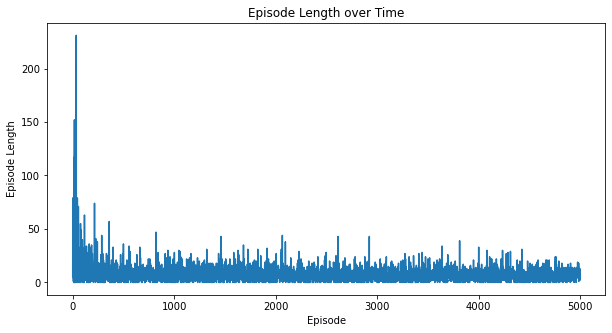

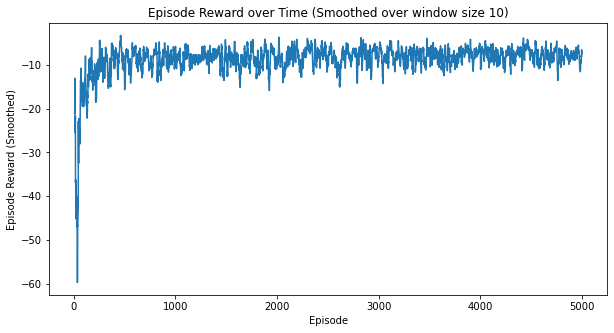

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [15]:
#POLICY GRADIENT:
para,stats = policyGradient(env, 5000)
plot_episode_stats(stats)

Episode 5000/5000.

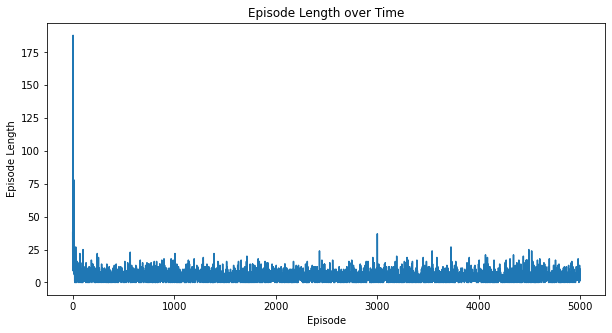

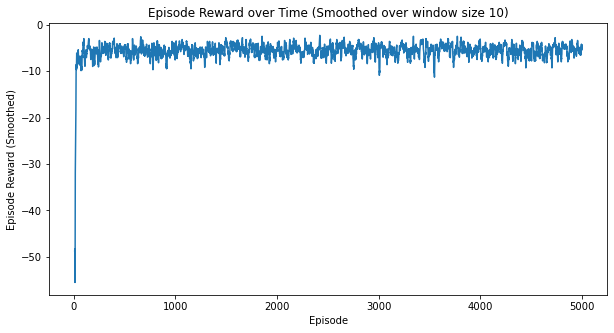

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [12]:
#Q-lEARNING:
Q, stats = q_learning(env, 5000)
plot_episode_stats(stats)